In [1]:
include(raw"C:\Users\palmi\.julia\packages\TurchinReg\E89UL\src\TurchinReg.jl")
import .TurchinReg as reg

In [2]:
import Statistics
using BAT, AdvancedHMC, DynamicHMC
using QuadGK

In [3]:
using DelimitedFiles
using HDF5
using JSON
using Memoize

In [4]:
using Plots
plotly()
gr(size=(500,500), html_output_format=:png);

┌ Info: For saving to png with the Plotly backend ORCA has to be installed.
└ @ Plots C:\Users\palmi\.julia\packages\Plots\cc8wh\src\backends.jl:363


In [5]:
data_p = Dict()

filename = "result_detail.hdf5"

theta_distr = []

ligo = h5open(filename, "r")
for elem in keys(ligo)
    m = ligo[elem]
    j = JSON.parse(read(m)["meta"])
    data_array = [elem.event for elem in read(m)["deposit"]]
    energy_value = j["values"]["macros"]["energy"]
    theta = j["values"]["macros"]["theta"]
    if theta == 0
        if !haskey(data_p, energy_value)
            data_p[energy_value] = []
        end
        append!(data_p[energy_value], data_array)
    end
end

close(ligo)


In [6]:
data_experiment = float(open(readdlm,"means_calibrated.txt"))[1:10]
sig_experiment = float(open(readdlm,"errors_calibrated.txt"))[1:10]/3

10-element Vector{Float64}:
 0.19102110734991762
 0.26308799426603496
 0.2778921079259129
 0.29567898912428564
 0.2722875261090444
 0.2865573917251221
 0.3382708512904677
 0.4011681120184571
 0.6416078032342039
 0.8736648244335322

In [7]:
E_min = 60.0
E_max = 80.0
n_disks = 10

10

In [8]:
@memoize function K_p(E, y, data_p=data_p)
    return Statistics.mean([elem[y] for elem in data_p[E]])
end

energy_p = sort(collect(keys(data_p)));
energy_p = energy_p[[x >= E_min for x in energy_p]];
energy_p_f = convert(Array{Float64,1}, energy_p)

401-element Vector{Float64}:
 60.0
 60.05
 60.099999999999994
 60.14999999999999
 60.19999999999999
 60.249999999999986
 60.29999999999998
 60.34999999999998
 60.39999999999998
 60.449999999999974
 60.49999999999997
 60.54999999999997
 60.599999999999966
  ⋮
 79.4499999999989
 79.49999999999889
 79.54999999999889
 79.59999999999889
 79.64999999999888
 79.69999999999888
 79.74999999999888
 79.79999999999887
 79.84999999999887
 79.89999999999887
 79.94999999999887
 79.99999999999886

In [9]:
#p = plot()
#for e in energy_p
 #   p = plot!(collect(range(1, stop=n_disks)), [K_cont_p(e, y_) for y_ in collect(range(1, stop=n_disks))], label="")
#end
#savefig("julia_plots/proton_losses.png")
#display(p)

In [10]:
@memoize function K_cont_p(E, y)
    if E < E_min
        E = E_min
    end
    
    if E > E_max
        E = E_max
    end
    
    if E in energy_p_f
        return K_p(E, y)
    end
    
    E_higher = energy_p_f[findfirst(x -> x>=E, energy_p_f)]
    E_lower = energy_p_f[findlast(x -> x<=E, energy_p_f)]
    return (K_p(E_lower, y) * (E_higher - E) + K_p(E_higher, y) * (E - E_lower)) / (E_higher - E_lower)
end

K_cont_p (generic function with 1 method)

In [63]:
K_cont_p(1, 1)

4.776127924119555

In [127]:
a = E_min+0.00001
b = E_max-0.00001
basis = reg.CubicSplineBasis(a, b, 150, (nothing, "dirichlet"));
Omega = reg.omega(basis, 2);

algo = reg.Analytically()
#alphas = reg.ArgmaxBAT()
phi_bounds = reg.PhiBounds()

┌ Info: Calculating omega matrix for Cubis spline basis derivatives of order 2...
└ @ Main.TurchinReg C:\Users\palmi\.julia\packages\TurchinReg\E89UL\src\bases\cubic_spline.jl:103
┌ Info: Omega caclulated successfully.
└ @ Main.TurchinReg C:\Users\palmi\.julia\packages\TurchinReg\E89UL\src\bases\cubic_spline.jl:117


Main.TurchinReg.PhiBounds(nothing, nothing, nothing, nothing)

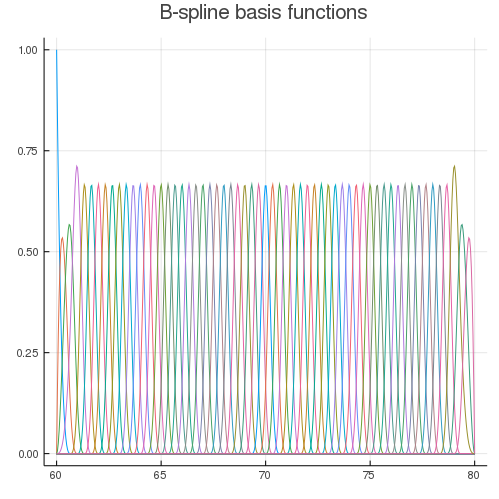

In [123]:
p = plot()
for func in basis.basis_functions
    p = plot!(x, func.(x), title="B-spline basis functions", legend=false, show = true)
end
#savefig("julia_plots/60_splines.png")
display(p)

In [65]:
#kernel_name = "gaussian"
#kernel(x::Real, y::Real) = reg.getOpticsKernels(kernel_name)(x, y)
kernel(x::Real, y::Real) = K_cont_p(x, y)

kernel (generic function with 1 method)

In [74]:
isfinite(kernel(1, 1))

true

In [128]:
@time result = reg.solve(
    basis,
    data_experiment,
    sig_experiment,
    K_cont_p,
    collect(range(1, stop=n_disks)),
    reg.Analytically(),
#     AHMCSampling(nothing, 1, 1000000),
#     DHMCSampling(nothing, 1, 10000),
    reg.User([0.001]),
    [Omega],
    phi_bounds,
    );

┌ Info: Checking data
└ @ Main.TurchinReg C:\Users\palmi\.julia\packages\TurchinReg\E89UL\src\solvers\solve.jl:29


177.149123 seconds (3.50 G allocations: 92.865 GiB, 14.10% gc time)


┌ Info: Starting discretize kernel...
└ @ Main.TurchinReg C:\Users\palmi\.julia\packages\TurchinReg\E89UL\src\bases\utils.jl:20
┌ Info: Kernel was discretized successfully.
└ @ Main.TurchinReg C:\Users\palmi\.julia\packages\TurchinReg\E89UL\src\bases\utils.jl:32
┌ Info: Finding optimal alpha
└ @ Main.TurchinReg C:\Users\palmi\.julia\packages\TurchinReg\E89UL\src\solvers\solve.jl:35
┌ Info: Optimal alpha found
└ @ Main.TurchinReg C:\Users\palmi\.julia\packages\TurchinReg\E89UL\src\solvers\solve.jl:37
┌ Info: Starting solution
└ @ Main.TurchinReg C:\Users\palmi\.julia\packages\TurchinReg\E89UL\src\solvers\solve.jl:54
┌ Info: Solved analytically
└ @ Main.TurchinReg C:\Users\palmi\.julia\packages\TurchinReg\E89UL\src\solvers\analytically.jl:5


In [131]:
x = collect(range(a, b, length=500))

phi_reconstructed =result.solution_function.(x)
phi_reconstructed_errors = result.error_function.(x)

plot(x, phi_reconstructed, #ribbon=phi_reconstructed_errors, fillalpha=0.3,
    label="Reconstructed spectrum", xlabel="E, MeV", ylabel="dN/dE", color = :blue,
    xtickfontsize=14,ytickfontsize=14, legendfontsize=14, guidefont=font(14), dpi=400,# yscale=:log10,
    minorgrid=true, ylims=[0, 0.4])
#savefig("julia_plots/reconstructed_60_splines_alpha_001.png")

In [23]:
K_p_matrix = reg.discretize_kernel(basis, K_cont_p, collect(range(1, stop=n_disks)));

┌ Info: Starting discretize kernel...
└ @ Main.TurchinReg C:\Users\palmi\.julia\packages\TurchinReg\E89UL\src\bases\utils.jl:20
┌ Info: Kernel was discretized successfully.
└ @ Main.TurchinReg C:\Users\palmi\.julia\packages\TurchinReg\E89UL\src\bases\utils.jl:32


In [24]:
res = K_p_matrix \ data_experiment;

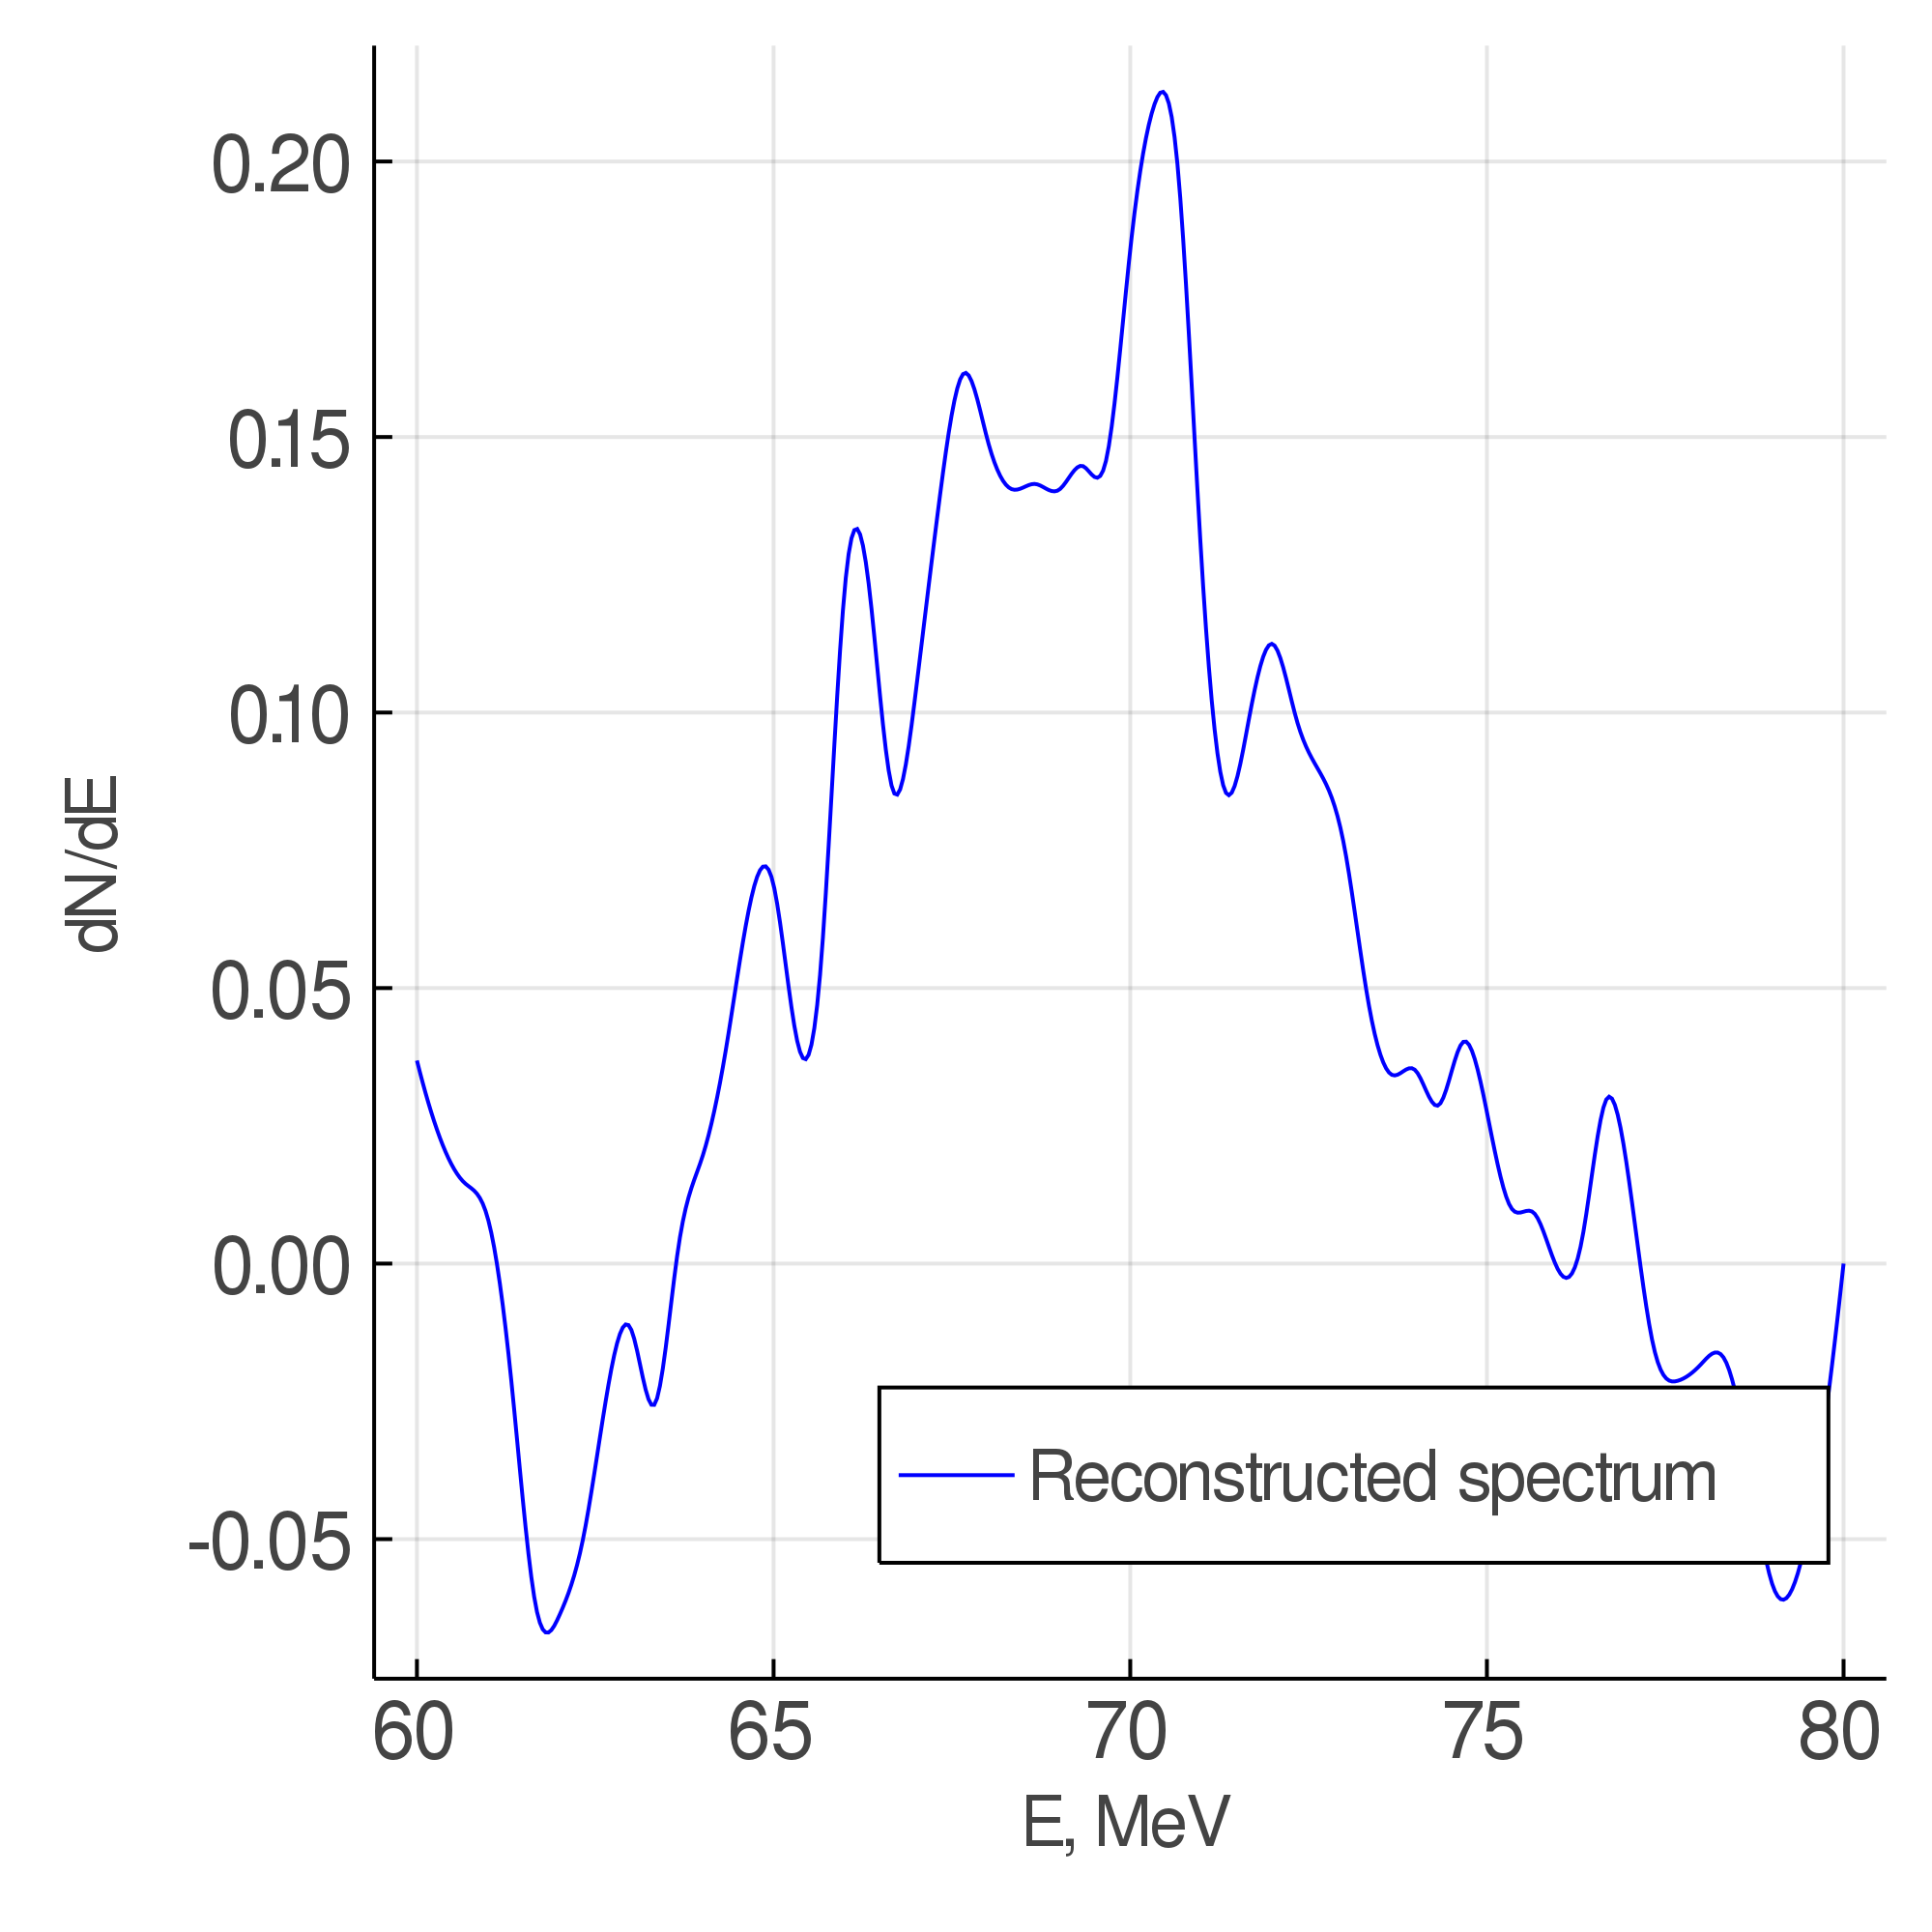

In [35]:
result_matrix = Dict()
result_matrix["coeff"] = res
phivec_matrix = reg.PhiVec(result_matrix, basis)
x = collect(range(a, b, length=500))
phi_reconstructed_matrix = phivec_matrix.solution_function.(x)


plot(x, phi_reconstructed_matrix,# ribbon=phi_reconstructed_errors, fillalpha=0.3,
     label="Reconstructed spectrum", xlabel="E, MeV", ylabel="dN/dE", color = :blue,
     xtickfontsize=14,ytickfontsize=14, legendfontsize=12, guidefont=font(12), dpi=400, legend=:bottomright)#,
 #yscale=:log10, xscale=:log10)
#savefig("julia_plots/reconstructed_from_matrix.png")

In [11]:
function create_spectrum_p(n_energy, energy_p)
    arr = []
    for (n, i) in zip(n_energy, energy_p)
        value = data_p[i]
        data_arr = sample(value, n)
        append!(arr, data_arr)
    end
    return sum(arr)
end

create_spectrum_p (generic function with 1 method)

In [25]:
function real_spectrum_p(E)
    C = 1.35 * 10^9
    ga = 1.04
    gb = 3.52
    E0 = 27.4
    dt = 1.19 * 10^5
    S = 10
    
    if E < (gb - ga) * E0
        return C * E^(-ga) * exp(- E / E0) / dt * S
    else
        return C * E^(-gb) * ((gb-ga) * E0)^(gb-ga) * exp(ga-gb) / dt * S
    end
end


real_spectrum_p (generic function with 1 method)

In [26]:
arr_spectrum_real_p = [floor(Int, real_spectrum_p(x_)) for x_ in energy_p_f]
f_y_p = create_spectrum_p(arr_spectrum_real_p, energy_p_f);

LoadError: InexactError: trunc(Int64, Inf)

In [14]:
sig = 0.01*f_y_p + [max(sqrt(i), 1) for i in f_y_p]
f = f_y_p;

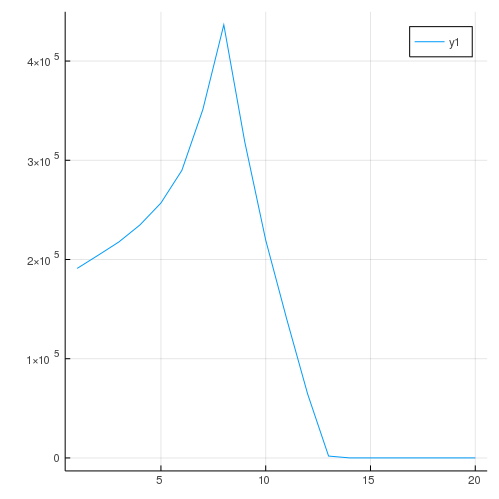

In [15]:
plot(f_y_p)

In [16]:
f

20-element Vector{Float64}:
 191008.234646601
 204232.24637450866
 217793.7381989306
 234860.93247605022
 256957.0706718971
 289857.1989820097
 351118.91445416544
 436556.3579519667
 318530.57619584934
 219517.26666726475
 140146.9474480673
  64485.25393676312
   1886.2417287431765
     41.14114665332133
     21.260359563334156
     31.27090041727174
     12.583227812014465
     19.66781113810472
      6.74671947336456
      1.9301482790854005

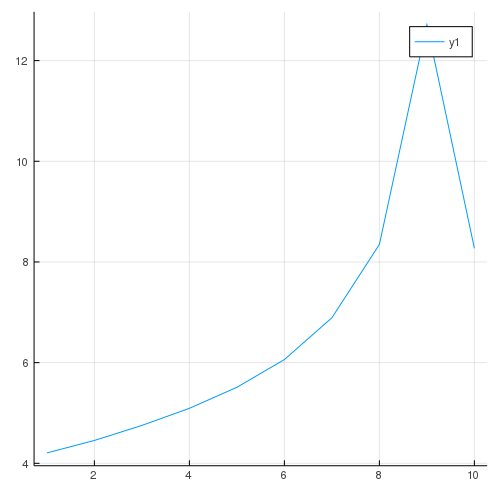

In [17]:
plot(data_experiment)